# Energy Demand Forecasting with Temporal Fusion Transformer

In [33]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
print(os.getenv("PYTORCH_ENABLE_MPS_FALLBACK"))

1


In [34]:
import warnings
import pickle
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorboard as tb

In [35]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
# !unzip LD2011_2014.txt.zip

In [36]:

data = pd.read_csv('LD2011_2014.txt', index_col=0, sep=';', decimal=',')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
data.tail()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [38]:
data = data.resample('1h').mean().replace(0., np.nan)
earliest_time = data.index.min()
df=data[['MT_002']]   ### picking only one customer power consumption

In [39]:
df

,MT_002
2011-01-01 00:00:00,NaN
2011-01-01 01:00:00,NaN
2011-01-01 02:00:00,NaN
2011-01-01 03:00:00,NaN
2011-01-01 04:00:00,NaN
...,...
2014-12-31 20:00:00,25.248933
2014-12-31 21:00:00,22.759602
2014-12-31 22:00:00,22.048364
2014-12-31 23:00:00,21.337127


In [40]:
for label in df:
    print(label)

MT_002


In [41]:
df_list = []

for label in df:

    ts = df[label]
    
    print(ts.fillna(method='ffill').dropna().index)
    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)

    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index

    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['consumer_id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()
     

<ipython-input-41-3c0b63d8d5ad>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  print(ts.fillna(method='ffill').dropna().index)
<ipython-input-41-3c0b63d8d5ad>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  start_date = min(ts.fillna(method='ffill').dropna().index)


DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 15:00:00', '2014-12-31 16:00:00',
               '2014-12-31 17:00:00', '2014-12-31 18:00:00',
               '2014-12-31 19:00:00', '2014-12-31 20:00:00',
               '2014-12-31 21:00:00', '2014-12-31 22:00:00',
               '2014-12-31 23:00:00', '2015-01-01 00:00:00'],
              dtype='datetime64[ns]', length=26305, freq='H')


<ipython-input-41-3c0b63d8d5ad>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  end_date = max(ts.fillna(method='bfill').dropna().index)


In [42]:
time_df

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1
...,...,...,...,...,...,...,...,...,...
23539,34.850640,32299,1345,2014-09-07 19:00:00,MT_002,19,7,6,9
23540,34.850640,32300,1345,2014-09-07 20:00:00,MT_002,20,7,6,9
23541,32.894737,32301,1345,2014-09-07 21:00:00,MT_002,21,7,6,9
23542,32.183499,32302,1345,2014-09-07 22:00:00,MT_002,22,7,6,9


In [43]:
### preparing the data for test and validation

test_df = time_df.iloc[:24,:]
### saving the Test Dataframe for the future infrencing
test_df.to_csv("Electric-consuption.csv")

In [44]:
time_df1 = time_df.iloc[24:,:]

The time_df is now in the proper format for the TimeSeriesDataset. As you have guessed by now, since the granularity is hourly, the hours_from_start variable will be the time index.



# Exploratory Data Analysis
The choice of 5 consumers/time-series is not random. The power usage of each time-series has different properties, such as the mean value:

In [45]:
time_df1[['consumer_id','power_usage']].groupby('consumer_id').mean()

,power_usage
consumer_id,
MT_002,27.478394


### Create DataLoaders

In [46]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = time_df1["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df1[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df1, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Baseline Model
Next, the step that almost everyone forgets: A baseline model. Especially in time-series forecasting, you will be surprised at how often a naive predictor outperforms even a fancier model!

As a naive baseline, we predict the power usage curve of the previous day:

In [47]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cpu")
baseline_predictions = Baseline().predict(val_dataloader).to('cpu')
(actuals - baseline_predictions).abs().mean().item()

/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


2.6078708171844482

### Training the Temporal Fusion Transformer Model

In [24]:
### No need to run everytime


early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='cpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type   

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 93/93 [01:41<00:00,  0.92it/s, v_num=5, train_loss_step=1.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 93/93 [01:42<00:00,  0.91it/s, v_num=5, train_loss_step=1.660, val_loss=1.200, train_loss_epoch=2.610]

Metric val_loss improved. New best score: 1.200


Epoch 1: 100%|██████████| 93/93 [01:42<00:00,  0.91it/s, v_num=5, train_loss_step=1.550, val_loss=1.200, train_loss_epoch=2.610]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 93/93 [01:39<00:00,  0.94it/s, v_num=5, train_loss_step=1.060, val_loss=1.260, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 93/93 [01:39<00:00,  0.94it/s, v_num=5, train_loss_step=1.060, val_loss=0.981, train_loss_epoch=1.180]

Metric val_loss improved by 0.219 >= min_delta = 0.0001. New best score: 0.981


Epoch 3: 100%|██████████| 93/93 [01:41<00:00,  0.92it/s, v_num=5, train_loss_step=0.983, val_loss=0.981, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 93/93 [01:41<00:00,  0.92it/s, v_num=5, train_loss_step=0.983, val_loss=0.791, train_loss_epoch=1.080]

Metric val_loss improved by 0.190 >= min_delta = 0.0001. New best score: 0.791


Epoch 4: 100%|██████████| 93/93 [01:34<00:00,  0.98it/s, v_num=5, train_loss_step=1.050, val_loss=0.791, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 93/93 [01:34<00:00,  0.98it/s, v_num=5, train_loss_step=0.796, val_loss=0.828, train_loss_epoch=0.996]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 93/93 [01:38<00:00,  0.95it/s, v_num=5, train_loss_step=0.667, val_loss=0.875, train_loss_epoch=0.933]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 93/93 [01:38<00:00,  0.94it/s, v_num=5, train_loss_step=0.667, val_loss=0.671, train_loss_epoch=0.832]

Metric val_loss improved by 0.120 >= min_delta = 0.0001. New best score: 0.671


Epoch 7: 100%|██████████| 93/93 [01:41<00:00,  0.92it/s, v_num=5, train_loss_step=0.794, val_loss=0.671, train_loss_epoch=0.832]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 93/93 [01:41<00:00,  0.92it/s, v_num=5, train_loss_step=0.794, val_loss=0.633, train_loss_epoch=0.739]

Metric val_loss improved by 0.038 >= min_delta = 0.0001. New best score: 0.633


Epoch 8: 100%|██████████| 93/93 [01:38<00:00,  0.95it/s, v_num=5, train_loss_step=0.670, val_loss=0.633, train_loss_epoch=0.739]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 93/93 [01:40<00:00,  0.92it/s, v_num=5, train_loss_step=0.718, val_loss=0.694, train_loss_epoch=0.699]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 93/93 [01:41<00:00,  0.92it/s, v_num=5, train_loss_step=0.718, val_loss=0.607, train_loss_epoch=0.668]

Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.607


Epoch 10: 100%|██████████| 93/93 [01:37<00:00,  0.96it/s, v_num=5, train_loss_step=0.711, val_loss=0.607, train_loss_epoch=0.668]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 93/93 [01:37<00:00,  0.95it/s, v_num=5, train_loss_step=0.711, val_loss=0.582, train_loss_epoch=0.633]

Metric val_loss improved by 0.025 >= min_delta = 0.0001. New best score: 0.582


Epoch 11: 100%|██████████| 93/93 [01:34<00:00,  0.98it/s, v_num=5, train_loss_step=0.544, val_loss=0.582, train_loss_epoch=0.633]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 93/93 [01:34<00:00,  0.98it/s, v_num=5, train_loss_step=0.746, val_loss=0.725, train_loss_epoch=0.607]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 93/93 [01:36<00:00,  0.96it/s, v_num=5, train_loss_step=0.538, val_loss=0.769, train_loss_epoch=0.578]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 93/93 [01:35<00:00,  0.98it/s, v_num=5, train_loss_step=0.516, val_loss=0.704, train_loss_epoch=0.549]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 93/93 [01:33<00:00,  0.99it/s, v_num=5, train_loss_step=0.548, val_loss=0.756, train_loss_epoch=0.521]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 93/93 [01:34<00:00,  0.99it/s, v_num=5, train_loss_step=0.548, val_loss=0.787, train_loss_epo

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.582. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 93/93 [01:34<00:00,  0.99it/s, v_num=5, train_loss_step=0.548, val_loss=0.787, train_loss_epoch=0.503]


In [48]:
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = "lightning_logs/lightning_logs/version_5/checkpoints/epoch=15-step=1488.ckpt"
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_5/checkpoints/epoch=15-step=1488.ckpt


/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [27]:
!zip  -r model_1_consumer.zip lightning_logs/lightning_logs/version_5/*

updating: lightning_logs/lightning_logs/version_5/01488/ (stored 0%)
updating: lightning_logs/lightning_logs/version_5/01488/consumer_id/ (stored 0%)
updating: lightning_logs/lightning_logs/version_5/01488/consumer_id/metadata.tsv (stored 0%)
updating: lightning_logs/lightning_logs/version_5/01488/consumer_id/tensors.tsv (stored 0%)
updating: lightning_logs/lightning_logs/version_5/checkpoints/ (stored 0%)
updating: lightning_logs/lightning_logs/version_5/checkpoints/epoch=15-step=1488.ckpt (deflated 8%)
updating: lightning_logs/lightning_logs/version_5/events.out.tfevents.1702296817.SYNBLRMAC6KKVNWQ.local.51023.1 (deflated 5%)
updating: lightning_logs/lightning_logs/version_5/hparams.yaml (deflated 91%)
updating: lightning_logs/lightning_logs/version_5/projector_config.pbtxt (deflated 39%)


To load the model again, unzip model.zip and execute the following — just remember the best model path:

In [49]:
#load our saved model again
# !unzip model.zip
best_model_path='lightning_logs/lightning_logs/version_5/checkpoints/epoch=15-step=1488.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [50]:
!pwd

/Users/rajeshthakur/Desktop/synechron/projects/time-series/pytoch-forcasting


# Check Tensorboard
Take a closer look at training and validation curves with Tensorboard:

In [51]:
# Start tensorboard
%load_ext tensorboard
%tensorboard - logdir lightning_logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/Users/rajeshthakur/miniconda3/envs/pytorch/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.core import core_plugin
  File "/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/tensorboard/plugins/core/core_plugin.py", line 32, in <module>
    from tensorboard.util import grpc_util
  File "/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/tensorboard/util/grpc_util.py", line 24, in <module>
    import grpc
  File "/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/grpc/__

In [45]:
!export PYTORCH_ENABLE_MPS_FALLBACK=1

In [52]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cpu')
predictions = best_tft.predict(val_dataloader)

actuals
#average p50 loss overall
# print((actuals - predictions).abs().mean().item()).to('cpu')

/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor([[31.1166, 25.9602, 24.7155, 24.7155, 24.5377, 27.7383, 29.1607, 29.6942,
         30.0498, 35.2063, 34.8506, 34.8506, 33.9616, 33.0725, 32.0057, 31.4723,
         30.0498, 30.4054, 31.4723, 34.8506, 34.8506, 32.8947, 32.1835, 31.6501]])

In [53]:
predictions = predictions.to('cpu')

In [54]:
#average p50 loss overall
print((actuals - predictions).abs().mean().item())

1.329045295715332


In [55]:
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

tensor([1.3290])


### Plot Predictions on Validation Data
If we pass the mode=raw on the predict() method, we get more information, including predictions for all seven quantiles. We also have access to the attention values (more about that later).



In [56]:
#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)
#torch.Size([5, 24, 7])

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([1, 24, 7])


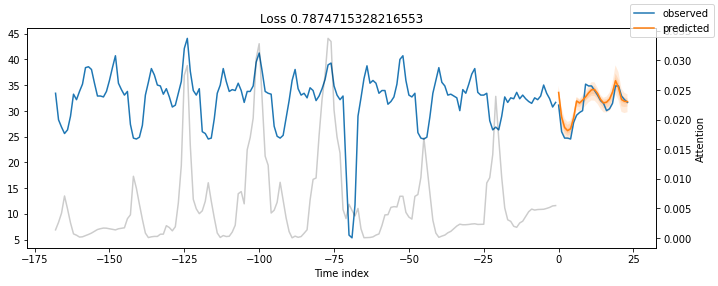

In [57]:
for idx in range(1):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)


### Plot Predictions For A Specific Time Series
Previously, we plot predictions on the validation data using the idx argument, which iterates over all time-series in our dataset. We can be more specific and output predictions on a specific time-series:

In [58]:
time_df1

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17568,23.826458,26328,1097,2014-01-02 00:00:00,MT_002,0,2,3,1
17569,22.048364,26329,1097,2014-01-02 01:00:00,MT_002,1,2,3,1
17570,21.337127,26330,1097,2014-01-02 02:00:00,MT_002,2,2,3,1
17571,21.159317,26331,1097,2014-01-02 03:00:00,MT_002,3,2,3,1
17572,21.337127,26332,1097,2014-01-02 04:00:00,MT_002,4,2,3,1
...,...,...,...,...,...,...,...,...,...
23539,34.850640,32299,1345,2014-09-07 19:00:00,MT_002,19,7,6,9
23540,34.850640,32300,1345,2014-09-07 20:00:00,MT_002,20,7,6,9
23541,32.894737,32301,1345,2014-09-07 21:00:00,MT_002,21,7,6,9
23542,32.183499,32302,1345,2014-09-07 22:00:00,MT_002,22,7,6,9


In [59]:
type(training)

pytorch_forecasting.data.timeseries.TimeSeriesDataSet

/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:105: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 24, 4, 168]). Returning list instead of torch.Tensor.
  warnings.warn(


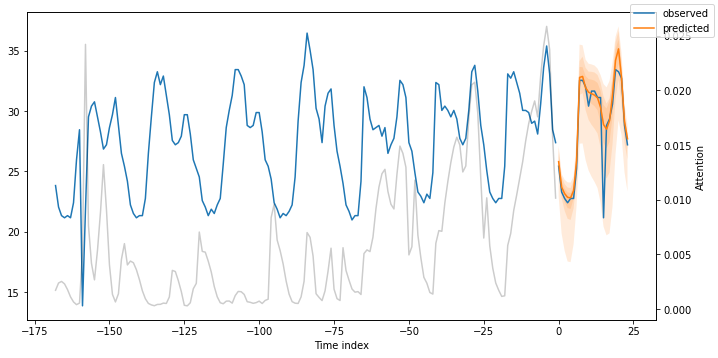

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))

### Removed this
###  & (x.time_idx_first_prediction == 32303)
raw_prediction= best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_002")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, ax=ax);

In Figure 7, we plot the day-ahead of MT_004 consumer for time index=26512.

Remember, our time-indexing column hours_from_start starts from 26304 and we can get predictions from 26388 onwards (because we set earlier min_encoder_length=max_encoder_length // 2 which equals 26304 + 168//2=26388

2014-09-07 23:00:00




### Out-of-Sample Forecasts

Let’s create out-of-sample predictions, beyond the final datapoint of validation data — which is 2014–09–07 23:00:00

All we have to do is to create a new dataframe that contains:

The number of N=max_encoder_length past dates, which act as the lookback window — the encoder data in TFT terminology.
The future dates of size max_prediction_length for which we want to compute our predictions — the decoder data.
We can create predictions for all 5 of our time-series, or just one. Figure 7 shows the out-of-sample predictions for consumer MT_002:

In [25]:
earliest_time = data.index.min()
earliest_time

Timestamp('2011-01-01 00:00:00')

In [26]:
last_data

NameError: name 'last_data' is not defined

/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


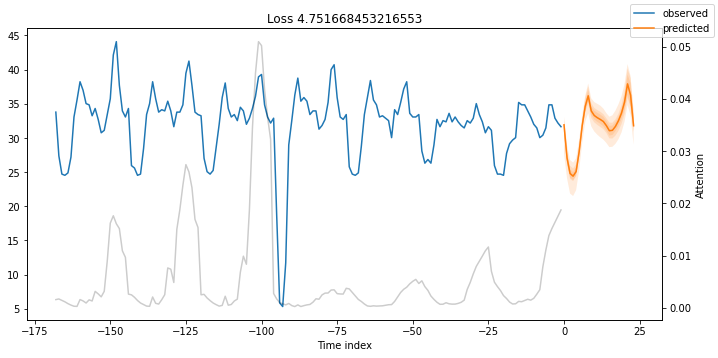

In [27]:
#encoder data is the last lookback window: we get the last 1 week (168 datapoints) for all 5 consumers = 840 total datapoints

encoder_data = time_df[lambda x: x.hours_from_start > x.hours_from_start.max() - max_encoder_length]
last_data = time_df[lambda x: x.hours_from_start == x.hours_from_start.max()]

# decoder_data = pd.concat(
#     [last_data.assign(date=lambda x: x.date + pd.offsets.Hour(i)) for i in range(1, max_prediction_length + 1)],
#     ignore_index=True,
# )

decoder_data = pd.read_csv('Electric-consuption.csv',index_col=0)

### We have to convert date column into datetime data
decoder_data['date'] = pd.to_datetime(decoder_data['date'])
decoder_data.dtypes
#decoder_data is the new dataframe for which we will create predictions. 
#decoder_data df should be max_prediction_length*consumers = 24*5=120 datapoints long : 24 datapoints for each cosnumer
#we create it by repeating the last hourly observation of every consumer 24 times since we do not really have new test data
#and later we fix the columns



decoder_data["hours_from_start"] = (decoder_data["date"] - earliest_time).dt.seconds / 60 / 60 + (decoder_data["date"] - earliest_time).dt.days * 24
decoder_data['hours_from_start'] = decoder_data['hours_from_start'].astype('int')
decoder_data["hours_from_start"] += encoder_data["hours_from_start"].max() + 1 - decoder_data["hours_from_start"].min()

decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["hour"] = decoder_data["date"].dt.hour.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)


fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" consumer_id == 'MT_002'")
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False, add_loss_to_title=QuantileLoss(), ax=ax);



In [28]:
# new_raw_predictions.output.prediction

# decoder_data.power_usage

# pd.read_csv('Electric-consuption.csv',index_col=0)

new_raw_predictions._fields


('output', 'x', 'index', 'decoder_lengths', 'y')

In [29]:
new_raw_predictions.index


### visualising the actual and predicted value

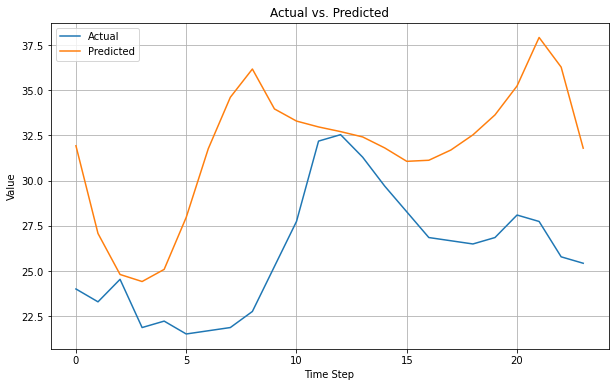

In [30]:

new_raw_predictions.output.encoder_lengths

actual_predicted_value = new_raw_predictions.x['decoder_target']

pred = new_raw_predictions.output.prediction
pred = torch.quantile(pred, q=0.5, dim=-1)

actual_predicted_value = actual_predicted_value.cpu().numpy()
pred_values = pred.cpu().numpy()

x_values = range(actual_predicted_value.shape[1])


plt.figure(figsize=(10, 6))
plt.plot(x_values, actual_predicted_value[0], label='Actual')
plt.plot(x_values, pred_values[0], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True)




In [31]:
actual_predicted_value[0]

array([24.004267, 23.29303 , 24.537695, 21.870554, 22.226173, 21.514936,
       21.692745, 21.870554, 22.759602, 25.248934, 27.738264, 32.1835  ,
       32.53912 , 31.294453, 29.694168, 28.271692, 26.849218, 26.671408,
       26.493599, 26.849218, 28.093884, 27.738264, 25.782362, 25.426743],
      dtype=float32)

In [32]:
import math
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
rmse = math.sqrt(mean_squared_error(actual_predicted_value[0],pred_values[0]))
print(f"RMSE:- {rmse}")

print(f"MAPE: {mean_absolute_percentage_error(actual_predicted_value[0],pred_values[0])}")

RMSE:- 6.8583060367947954
MAPE: 0.23211534321308136


### Feature-wise Interpretability
The Variable Selection Network component of TFT can easily estimate the feature importances:

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

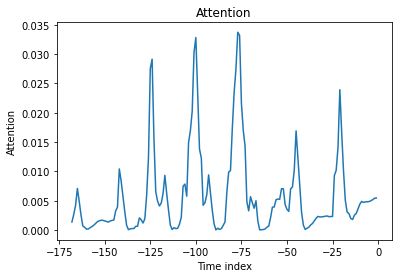

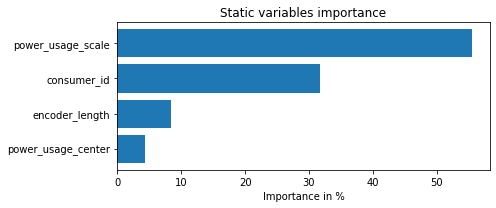

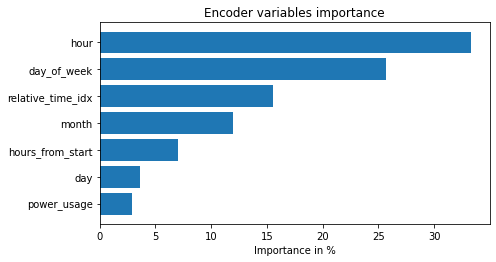

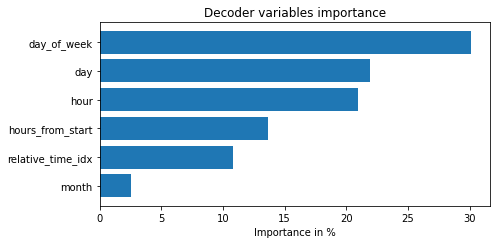

In [61]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'power_usage_center': <Figure size 720x360 with 2 Axes>,
 'power_usage_scale': <Figure size 720x360 with 2 Axes>,
 'hours_from_start': <Figure size 720x360 with 2 Axes>,
 'day': <Figure size 720x360 with 2 Axes>,
 'day_of_week': <Figure size 720x360 with 2 Axes>,
 'month': <Figure size 720x360 with 2 Axes>,
 'hour': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'power_usage': <Figure size 720x360 with 2 Axes>,
 'consumer_id': <Figure size 432x288 with 2 Axes>}

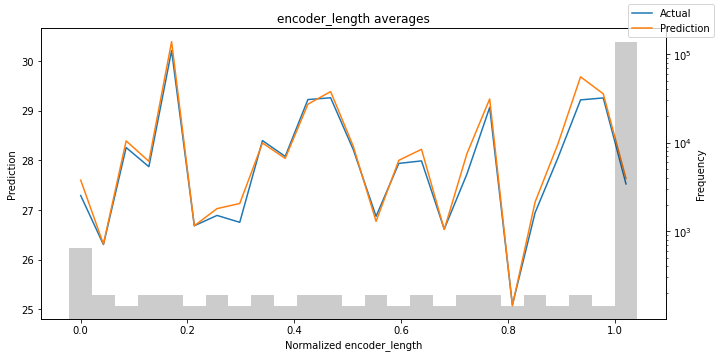

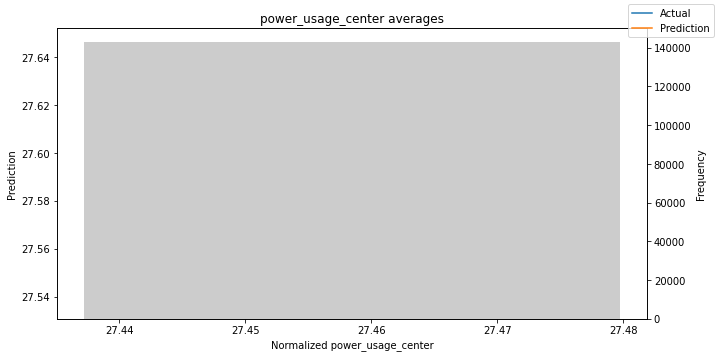

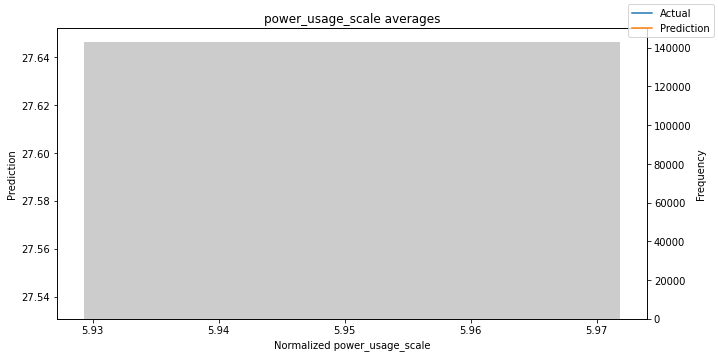

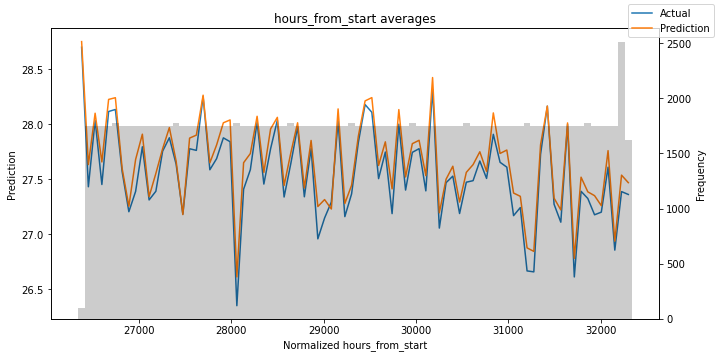

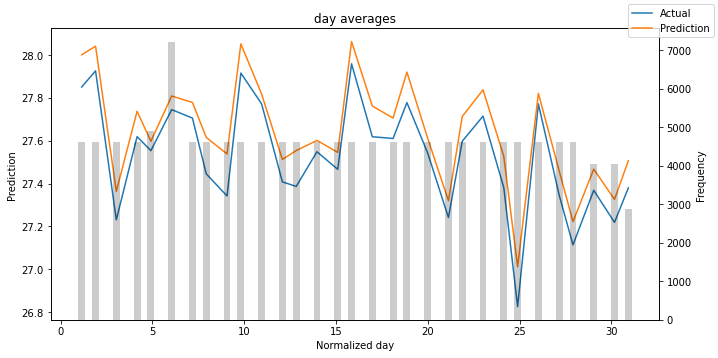

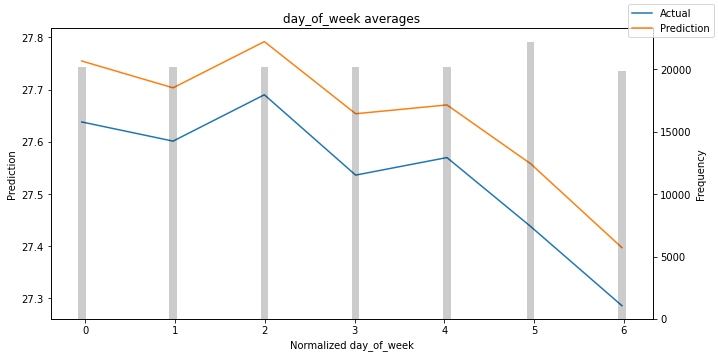

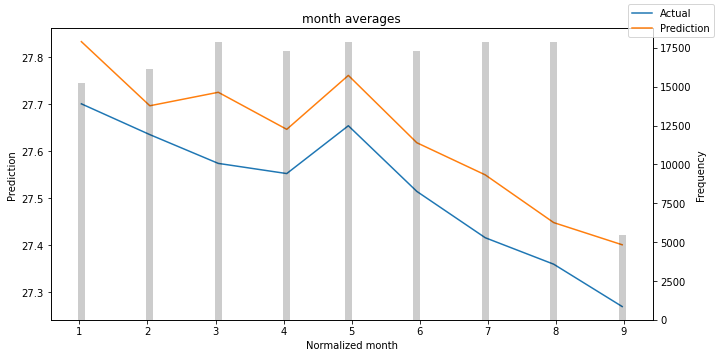

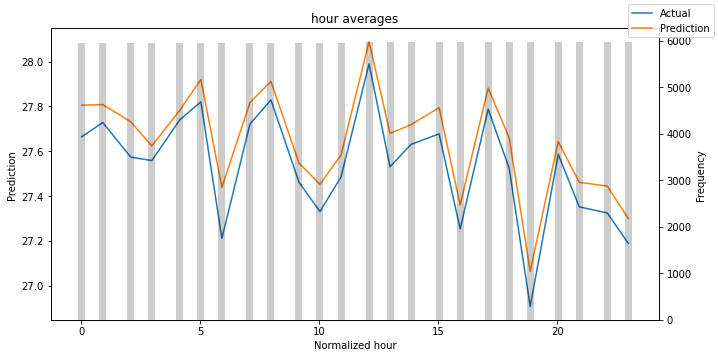

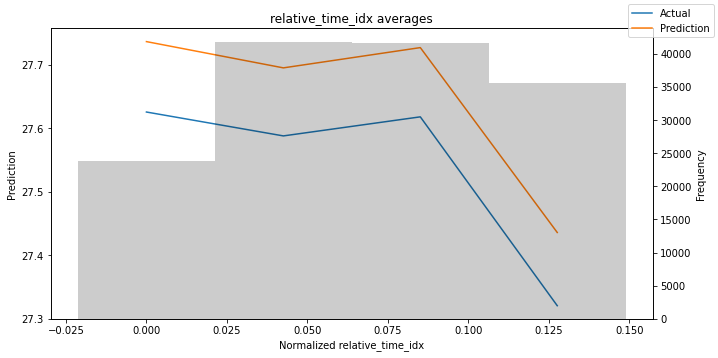

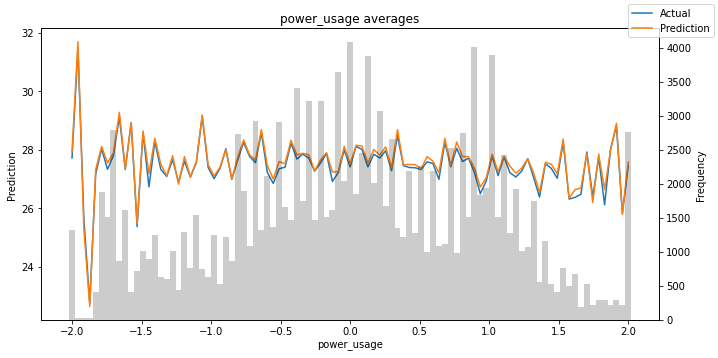

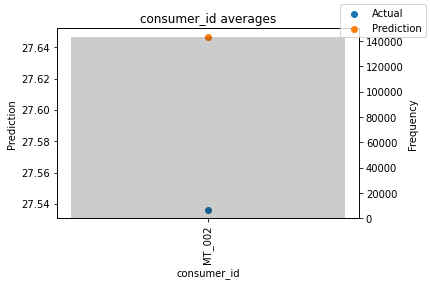

In [62]:
#Analysis on the training set

predictions = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

### Hyperparameter Tuning


In [63]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=1,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False 
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

[I 2023-12-14 18:08:47,065] A new study created in memory with name: no-name-306549ca-21a6-484c-bf4d-655a7dd0e645
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:124: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rajeshthakur/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

{'gradient_clip_val': 0.16777494570660917, 'hidden_size': 85, 'dropout': 0.182650737437083, 'hidden_continuous_size': 38, 'attention_head_size': 3, 'learning_rate': 0.07738040349013603}
